# English (Fasttext + BiLSTM + GeLU)

In [1]:
import codecs
import csv
import json
import logging
import os
import re
import sys
import time
from itertools import product

import dill
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
import wandb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
#from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    replacements = (
      ("“", ''), ("”", ''), ("//", ""), ("«", ''), ("»",''), (",", ''),
      (";", ''), (".", ''),
    #   ("?", ''), ("¿", ''), ("¡", ''), ("!", ''), ("-", ' '),
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    output = re.sub(r'(?is)\s+', ' ', output)
    return output.strip()


def metric2binary(meter, pad=11):
    return ([1 if syllable == "+" else 0 for syllable in meter] + [0] * (11 - len(meter)))[:pad]


def label2metric(label):
    return "".join("+" if l else "-" for l in label)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## English

In [12]:
# English
# English
en_test = (pd
    .read_csv("4b4v_prosodic_meter.csv")
    .assign(
        text=lambda x: x["text"].apply(clean_text),
        length=lambda x: x["meter"].str.len()
    )
    .drop_duplicates("text")
    .rename(columns={"line_text": "text", "metrical_pattern": "meter", "prosodic_meter": "sota"})
)
en_test = en_test.query("length in (5,6,7,8,9,10,11)")
pos_names = [f"pos{i}" for i in range(1, 12)]
pos_labels = en_test.meter.apply(metric2binary)
en_test["labels"] = pos_labels
en_test[pos_names] = pos_labels.tolist()
en_test[pos_names] = en_test[pos_names].astype(float)

en = (pd
    .read_json(open("ecpa.json"))
    .query("manually_checked == True")[["line_text", "metrical_pattern"]]
    .assign(
        line_text=lambda x: x["line_text"].apply(clean_text),
        metrical_pattern=lambda x: x["metrical_pattern"].str.replace("|", "").str.replace("(", "").str.replace(")", "")
    )
    .assign(
        length=lambda x: x["metrical_pattern"].str.len(),
    )
    .drop_duplicates("line_text")
    .rename(columns={"line_text": "text", "metrical_pattern": "meter", "prosodic_meter": "sota"})
)
en = en[~en["text"].isin(en_test["text"])].query("length in (5,6,7,8,9,10,11)")

pos_names = [f"pos{i}" for i in range(1, int(en.meter.str.len().max()) + 1)]
pos_labels = en.meter.apply(metric2binary)
en["labels"] = pos_labels
en[pos_names] = pos_labels.tolist()
en[pos_names] = en[pos_names].astype(float)

en["labels"] = en.meter.apply(metric2binary)
en_train, en_val = train_test_split(
    en[["text"] + pos_names], test_size=0.25, random_state=42)

In [13]:
en_test.head()

,text,meter,sota,length,labels,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11
0,Bright star would I were steadfast as thou art--,+-+--++--+,++-+-+--++,10,"[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]",1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,Not in lone splendour hung aloft the night,+-++-+-+-+,+-++-+-+-+,10,"[1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]",1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,And watching with eternal lids apart,-+-+-+-+-+,-+-+-+-+-+,10,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]",0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,Like nature's patient sleepless Eremite,-+-+-+--+-,-+-+-+-+-+,10,"[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]",0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,The moving waters at their priestlike task,-+-+-+-+-+,-+-+-+-+-+,10,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]",0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [5]:
#vectors_filename = "glove-sbwc.i25.vec"
#vectors_filename = "SBW-vectors-300-min5.vec"
#vectors_filename = "fasttext-SUC-embeddings-l-model.vec"
vectors_filename = "cc.en.300.vec"

if True:  # not os.path.isfile("embeddings_index.pkl"):
    def get_coefs(word, *vector):
        return word, np.asarray(vector, dtype='float32')
    with open(f"/home/jupyter/{vectors_filename}") as vec_file:
        embeddings_index = dict(
            get_coefs(*line.strip().split())
            for idx, line in enumerate(tqdm(vec_file))
            if idx != 0  # First line continas counts
        )
    #with open("embeddings_index.pkl", "wb") as embeddings_file:
    #    dill.dump(embeddings_index, embeddings_file)
else:
    with open("embeddings_index.pkl", "rb") as embeddings_file:
        embeddings_index = dill.load(embeddings_file)

2000001it [04:17, 7764.18it/s]


In [6]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
del all_embs
emb_mean, emb_std

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.001960038, 0.0732493)

In [14]:
embed_size = 300  # how big is each word vector
max_features = 10000  # how many unique words to use (i.e num rows in embedding vector)
maxlen = 24  # max number of words per input
y_train = en_train[pos_names].values
y_test = en_test[pos_names].values
y_val = en_val[pos_names].values

In [16]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(en_train.text.values))
tokenized_train = tokenizer.texts_to_sequences(en_train.text.values)
tokenized_val = tokenizer.texts_to_sequences(en_val.text.values)
tokenized_test = tokenizer.texts_to_sequences(en_test.text.values)
X_train = pad_sequences(tokenized_train, maxlen=maxlen, padding="post")
X_val = pad_sequences(tokenized_val, maxlen=maxlen, padding="post")
X_test = pad_sequences(tokenized_test, maxlen=maxlen, padding="post")

In [17]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = embeddings_index.get(word, embeddings_index.get(word.lower()))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
inp = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 300)           3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)               

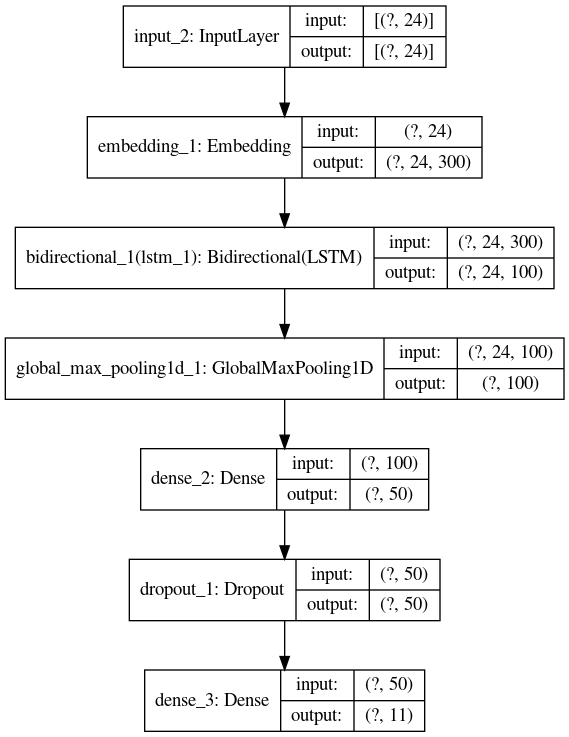

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
en_train.iloc[0].text

'Imperious came whose mansion stood'

In [29]:
X_train[0]

array([3120,  261,   79, 1751,  428,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [30]:
history10 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
706/706 [==============================] - 107s 151ms/step - loss: 0.0796 - accuracy: 0.2194 - val_loss: 0.0561 - val_accuracy: 2.6575e-04
Epoch 2/10
706/706 [==============================] - 106s 150ms/step - loss: 0.0583 - accuracy: 0.2514 - val_loss: 0.0552 - val_accuracy: 0.0098
Epoch 3/10
706/706 [==============================] - 106s 150ms/step - loss: 0.0552 - accuracy: 0.2974 - val_loss: 0.0549 - val_accuracy: 0.8231
Epoch 4/10
706/706 [==============================] - 105s 149ms/step - loss: 0.0534 - accuracy: 0.3653 - val_loss: 0.0539 - val_accuracy: 0.1378
Epoch 5/10
706/706 [==============================] - 104s 148ms/step - loss: 0.0516 - accuracy: 0.4149 - val_loss: 0.0564 - val_accuracy: 0.9564
Epoch 6/10
706/706 [==============================] - 105s 148ms/step - loss: 0.0507 - accuracy: 0.3253 - val_loss: 0.0544 - val_accuracy: 0.1458
Epoch 7/10
706/706 [==============================] - 105s 149ms/step - loss: 0.0485 - accuracy: 0.3232 - val_loss: 0.05

In [31]:
model.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 0s 14ms/step - loss: 1.5975 - accuracy: 0.0642


[1.5974586009979248, 0.06423982977867126]

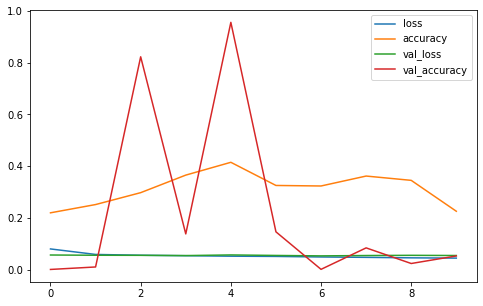

In [32]:
pd.DataFrame(history10.history).plot(figsize=(8,5))

In [33]:
history100 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
706/706 [==============================] - 104s 147ms/step - loss: 0.0422 - accuracy: 0.2298 - val_loss: 0.0587 - val_accuracy: 0.2725
Epoch 2/100
706/706 [==============================] - 103s 146ms/step - loss: 0.0416 - accuracy: 0.2621 - val_loss: 0.0564 - val_accuracy: 0.1780
Epoch 3/100
706/706 [==============================] - 103s 146ms/step - loss: 0.0388 - accuracy: 0.2447 - val_loss: 0.0575 - val_accuracy: 0.1633
Epoch 4/100
706/706 [==============================] - 103s 145ms/step - loss: 0.0376 - accuracy: 0.2428 - val_loss: 0.0594 - val_accuracy: 0.2531
Epoch 5/100
706/706 [==============================] - 104s 147ms/step - loss: 0.0361 - accuracy: 0.3271 - val_loss: 0.0591 - val_accuracy: 0.1479
Epoch 6/100
706/706 [==============================] - 103s 147ms/step - loss: 0.0346 - accuracy: 0.1567 - val_loss: 0.0611 - val_accuracy: 0.2396
Epoch 7/100
706/706 [==============================] - 102s 145ms/step - loss: 0.0326 - accuracy: 0.2186 - val_loss: 0

In [34]:
model.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 0s 13ms/step - loss: 7.2013 - accuracy: 0.1231


[7.201279640197754, 0.12312633544206619]

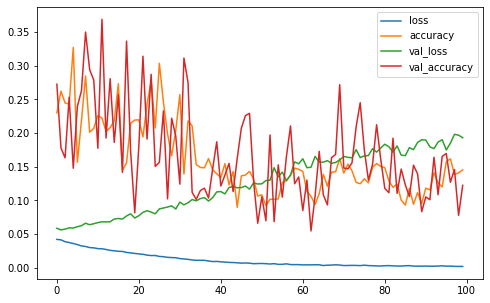

In [35]:
pd.DataFrame(history100.history).plot(figsize=(8,5))

---

In [36]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer

x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_gelu = Model(inputs=inputs, outputs=x)
model_gelu.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_gelu.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 24, 300)           3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 11)               

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.1 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last solutio

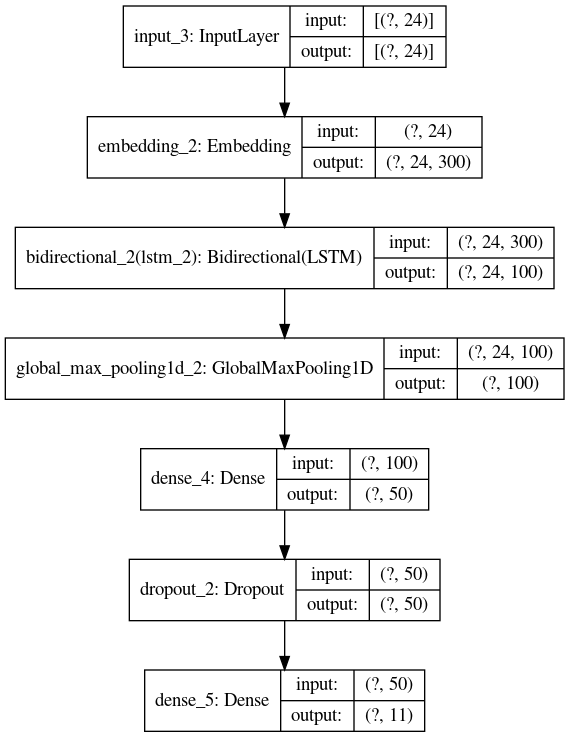

In [37]:
tf.keras.utils.plot_model(model_gelu, show_shapes=True)

In [38]:
history10_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
706/706 [==============================] - 122s 172ms/step - loss: 0.0786 - accuracy: 0.2536 - val_loss: 0.0553 - val_accuracy: 0.0238
Epoch 2/10
706/706 [==============================] - 121s 172ms/step - loss: 0.0491 - accuracy: 0.2991 - val_loss: 0.0571 - val_accuracy: 0.9922
Epoch 3/10
706/706 [==============================] - 121s 171ms/step - loss: 0.0346 - accuracy: 0.3421 - val_loss: 0.0617 - val_accuracy: 0.0081
Epoch 4/10
706/706 [==============================] - 121s 171ms/step - loss: 0.0239 - accuracy: 0.4006 - val_loss: 0.0748 - val_accuracy: 0.0183
Epoch 5/10
706/706 [==============================] - 121s 171ms/step - loss: 0.0177 - accuracy: 0.2801 - val_loss: 0.0816 - val_accuracy: 0.0069
Epoch 6/10
706/706 [==============================] - 121s 172ms/step - loss: 0.0138 - accuracy: 0.1533 - val_loss: 0.0882 - val_accuracy: 0.4059
Epoch 7/10
706/706 [==============================] - 121s 171ms/step - loss: 0.0108 - accuracy: 0.2084 - val_loss: 0.1015 -

In [39]:
model_gelu.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 0s 14ms/step - loss: 2.8187 - accuracy: 0.1456


[2.818662166595459, 0.1456102728843689]

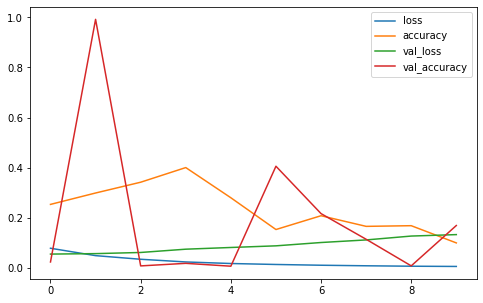

In [40]:
pd.DataFrame(history10_gelu.history).plot(figsize=(8,5))

In [41]:
history100_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
706/706 [==============================] - 121s 172ms/step - loss: 0.0053 - accuracy: 0.1196 - val_loss: 0.1443 - val_accuracy: 0.2385
Epoch 2/100
706/706 [==============================] - 121s 172ms/step - loss: 0.0044 - accuracy: 0.0974 - val_loss: 0.1512 - val_accuracy: 0.0961
Epoch 3/100
706/706 [==============================] - 121s 171ms/step - loss: 0.0040 - accuracy: 0.0896 - val_loss: 0.1596 - val_accuracy: 0.1286
Epoch 4/100
706/706 [==============================] - 121s 171ms/step - loss: 0.0038 - accuracy: 0.0944 - val_loss: 0.1588 - val_accuracy: 0.1020
Epoch 5/100
706/706 [==============================] - 121s 171ms/step - loss: 0.0033 - accuracy: 0.0922 - val_loss: 0.1657 - val_accuracy: 0.1217
Epoch 6/100
706/706 [==============================] - 121s 171ms/step - loss: 0.0031 - accuracy: 0.0939 - val_loss: 0.1735 - val_accuracy: 0.0945
Epoch 7/100
706/706 [==============================] - 121s 171ms/step - loss: 0.0028 - accuracy: 0.0910 - val_loss: 0

In [42]:
model_gelu.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 0s 13ms/step - loss: 3.5493 - accuracy: 0.1370


[3.5492725372314453, 0.1370449662208557]

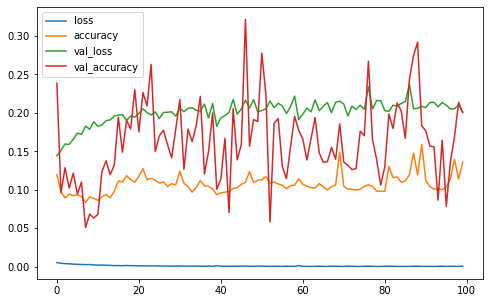

In [43]:
pd.DataFrame(history100_gelu.history).plot(figsize=(8,5))

---

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 24, 300)           3000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 50)            30200     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

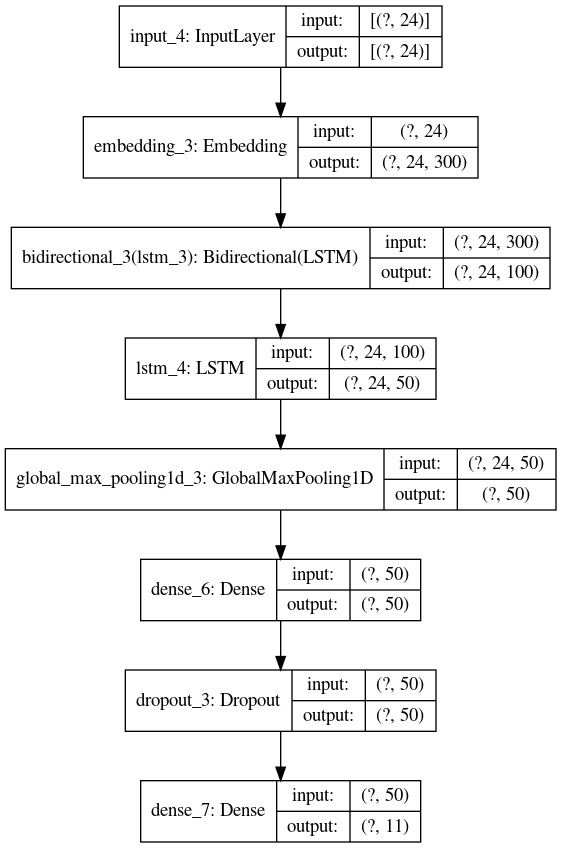

In [45]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_2lstm = Model(inputs=inputs, outputs=x)
model_2lstm.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_2lstm.summary()
tf.keras.utils.plot_model(model_2lstm, show_shapes=True)

In [46]:
history10_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
706/706 [==============================] - 174s 247ms/step - loss: 0.0849 - accuracy: 0.3214 - val_loss: 0.0565 - val_accuracy: 0.0144
Epoch 2/10
706/706 [==============================] - 174s 247ms/step - loss: 0.0533 - accuracy: 0.2646 - val_loss: 0.0568 - val_accuracy: 0.0432
Epoch 3/10
706/706 [==============================] - 173s 246ms/step - loss: 0.0406 - accuracy: 0.3078 - val_loss: 0.0605 - val_accuracy: 0.4809
Epoch 4/10
706/706 [==============================] - 173s 245ms/step - loss: 0.0323 - accuracy: 0.4033 - val_loss: 0.0697 - val_accuracy: 0.2337
Epoch 5/10
706/706 [==============================] - 173s 245ms/step - loss: 0.0260 - accuracy: 0.5094 - val_loss: 0.0737 - val_accuracy: 0.0000e+00
Epoch 6/10
706/706 [==============================] - 173s 245ms/step - loss: 0.0215 - accuracy: 0.5659 - val_loss: 0.0781 - val_accuracy: 0.9891
Epoch 7/10
706/706 [==============================] - 173s 246ms/step - loss: 0.0178 - accuracy: 0.7675 - val_loss: 0.08

In [47]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 1s 18ms/step - loss: 2.0080 - accuracy: 0.0632


[2.00797700881958, 0.06316916644573212]

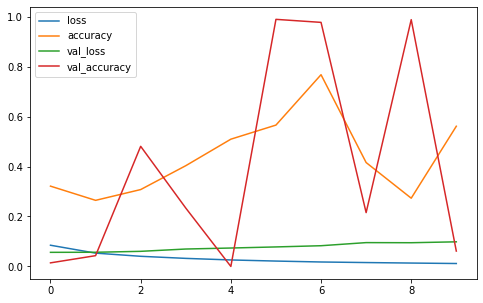

In [48]:
pd.DataFrame(history10_2lstm.history).plot(figsize=(8,5))

In [49]:
history100_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
706/706 [==============================] - 172s 244ms/step - loss: 0.0106 - accuracy: 0.1229 - val_loss: 0.1087 - val_accuracy: 0.0353
Epoch 2/100
706/706 [==============================] - 172s 244ms/step - loss: 0.0094 - accuracy: 0.0693 - val_loss: 0.1115 - val_accuracy: 0.1678
Epoch 3/100
706/706 [==============================] - 172s 244ms/step - loss: 0.0078 - accuracy: 0.0761 - val_loss: 0.1142 - val_accuracy: 0.1213
Epoch 4/100
706/706 [==============================] - 172s 244ms/step - loss: 0.0067 - accuracy: 0.0849 - val_loss: 0.1278 - val_accuracy: 0.1071
Epoch 5/100
706/706 [==============================] - 173s 244ms/step - loss: 0.0087 - accuracy: 0.0588 - val_loss: 0.1260 - val_accuracy: 0.1104
Epoch 6/100
706/706 [==============================] - 172s 243ms/step - loss: 0.0061 - accuracy: 0.0643 - val_loss: 0.1419 - val_accuracy: 0.0946
Epoch 7/100
706/706 [==============================] - 173s 245ms/step - loss: 0.0054 - accuracy: 0.0466 - val_loss: 0

In [50]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

30/30 [==============================] - 1s 20ms/step - loss: 3.2663 - accuracy: 0.5171


[3.266278028488159, 0.5171306133270264]

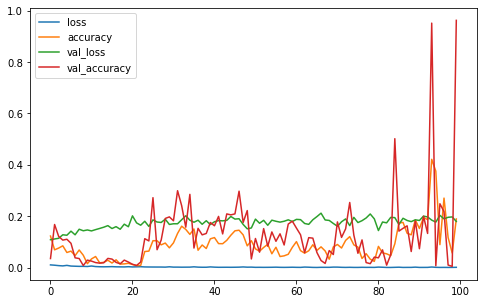

In [51]:
pd.DataFrame(history100_2lstm.history).plot(figsize=(8,5))